In [24]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
from scipy import stats
import requests
import random

Find a null expectation for the average growth rate of clades descending from mutations that occurred X independent times over the tree

To do this, find every mutation observed on the tree. Then randomly place it on a branch of the empirical tree. The structure of the tree and logistic growth rate will always be the same. The number of mutations per branch will be taken from the empirical distribution. Do this 100 times to find 100 randomized trees

Then, use these randomized trees to find the average logistic growth rate of clades that descend from a mutation that occurred X times across the tree.

In [23]:
#Download tree json
# tree_url = "https://data.nextstrain.org/ncov_global_2021-05-20.json"
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [5]:
sequences_file = 'global_subsampled_sequences.fasta'
record_dict = SeqIO.to_dict(SeqIO.parse(sequences_file, "fasta"))

In [22]:
# make dictionary with gene name as key and reference sequence of that gene as value

reference_sequence = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_seq = feature.location.extract(record.seq).translate()
            reference_sequence[feature.qualifiers['gene'][0]] = gene_seq


/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [41]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [42]:
def count_independent_occurrences(mutation_type):
    
    all_mutations = []


    #only look at mutations on internal branches
    for node in tree.find_clades(terminal=False):
        
        # only consider mutations on branches that give rise to a clade of at least 10 tips
        if len(node.get_terminals()) >=10:

            if hasattr(node, 'branch_attrs'):
                for gene, mut_list in node.branch_attrs["mutations"].items():
                    # not considering synonymous mutations for now
                    if gene!= 'nuc':
                        mut_list_consolidated = consolidate_deletions(mut_list)
                        for mut in mut_list_consolidated:
                            
                            if mutation_type == 'aa':
                                # look at specific nonsyn muts
                                gene_mutation = f'{gene}_{mut}'

                                
                            elif mutation_type == 'site':
                                # look at mutation to a codon (without regard to identity of mutation)
                                gene_mutation = f'{gene}_{mut[1:-1]}'
                            
                            # append mutation to a list of all observed mutations
                            # exclude if mutation is in stop codon position of gene
                            if int(mut[1:-1])!=len(reference_sequence[gene]):
                                all_mutations.append(gene_mutation)
                




    all_mutations_unique = list(set(all_mutations))    

    independent_occurrences_all_mutations = Counter(all_mutations)
    

    return all_mutations_unique, independent_occurrences_all_mutations


In [45]:
# make list of all nonsynonymous mutations observed on internal branches of tree 
# to be placed on tree at random
bag_of_mutations = [mut for mut,x in independent_occurrences_all_mutations.items() for y in range(x)]

In [26]:
# find distribution of muts on branch
mut_counts = []

for node in tree.find_clades():

    # still only considering branches that give rise to a clade of at least 10
    if len(node.get_terminals())>=10:

        if hasattr(node, 'branch_attrs'):
            mut_count = 0
            for gene, mut_list in node.branch_attrs["mutations"].items():
                
                # not considering synonymous mutations for now
                if gene!= 'nuc':
                    for mut in mut_list:

                        # append mutation to a list of all observed mutations
                        # exclude if mutation is in stop codon position of gene
                        if int(mut[1:-1])!=len(reference_sequence[gene]):
                            mut_count+=1
                            
            mut_counts.append(mut_count)
                            
# plt.hist(mut_counts)
                            


Randomize tree 100 times and find avg growth rate in clades descending from each mutation

In [47]:
possible_occurrences = list(set(independent_occurrences_all_mutations.values()))
mean_growth_by_num_occurrences = []

for i in range(100):
    # randomize positions of mutations on tree
    randomize_tree()
    
    # all_mutations_unique will be the same for randomized and empirical data
    growth_by_precedingmut_dict, s1muts_by_precedingmut_dict = clades_descending_from_randomized_mut(all_mutations_unique)
    
    growth_by_precedingmut_mean, s1muts_by_precedingmut_mean = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict)
    
    
    for mut, rate in growth_by_precedingmut_mean.items():
        num_occurrences = independent_occurrences_all_mutations[mut]
        
        mean_growth_by_num_occurrences.append({'num_occurrences':num_occurrences, 'rate': rate})


df = pd.DataFrame(mean_growth_by_num_occurrences)

In [48]:
occurrence_groups = df.groupby('num_occurrences')['rate']

percentile_cutoffs = []

for num, rates in occurrence_groups:
    lower_95_percentile = np.percentile(sorted(rates), 2.5)
    upper_95_percentile = np.percentile(sorted(rates), 97.5)
    percentile_cutoffs.append({'num_occurrences': num,
                              'lower_95': lower_95_percentile, 
                              'upper_95': upper_95_percentile})
percentile_cutoffs_df = pd.DataFrame(percentile_cutoffs)

In [49]:
percentile_cutoffs_df

,num_occurrences,lower_95,upper_95
0,1,-16.199077,6.926282
1,2,-13.911678,5.372867
2,3,-11.783742,4.241921
3,4,-9.392760,2.811455
4,5,-9.139112,2.887729
5,6,-9.594983,1.638466
6,7,-7.823017,1.731926
7,8,-7.420460,1.955433


In [52]:
# find what percentile of the expected distribution each mutation falls at

ORF1a_del_percentile =stats.percentileofscore(list(df[df['num_occurrences']==8]['rate']), 0.286002)

S_L452R_percentile =stats.percentileofscore(list(df[df['num_occurrences']==5]['rate']), 4.156651)

S_N501Y_percentile =stats.percentileofscore(list(df[df['num_occurrences']==4]['rate']), 0.365557)

S_P681H_percentile =stats.percentileofscore(list(df[df['num_occurrences']==7]['rate']), 0.435931)

S_G142D_percentile =stats.percentileofscore(list(df[df['num_occurrences']==5]['rate']), 6.435074)

S_E484K_percentile =stats.percentileofscore(list(df[df['num_occurrences']==8]['rate']), -1.261073)

print(S_L452R_percentile)

99.48979591836735


In [53]:
# manually add info for all muts over 5 occurrences on tree. Actually code this tomorrow

d = {'mutation': ['ORF1a_3675/3676/3677del', 'S_L452R', 'S_N501Y', 'S_P681H', 'S_G142D', 'S_E484K'], 
#      'num_occurrences': [6, 5, 5, 6], 
     'num_occurrences': [7, 4, 3, 6, 4, 7], 
     'rate': [0.286002, 4.156651, 0.365557, 0.43593, 6.4350741, -1.261073]}

empirical_df = pd.DataFrame(d)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

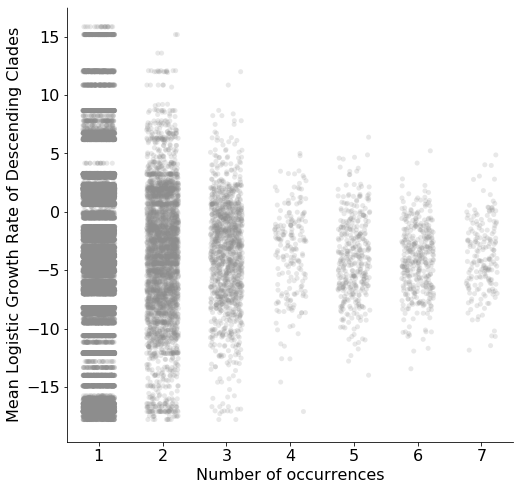

In [598]:
fig, ax = plt.subplots(figsize=(8,8))


sns.stripplot(x='num_occurrences', y='rate', data=df, 
              dodge=True, jitter=0.25, zorder=1,
              alpha=.2, color='#8d8d8d', ax=ax)

ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

ax.set_ylabel('Mean Logistic Growth Rate of Descending Clades', fontsize = 16)
ax.set_xlabel('Number of occurrences', fontsize = 16)

plt.yticks(fontsize= 16)
plt.xticks(fontsize= 16)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

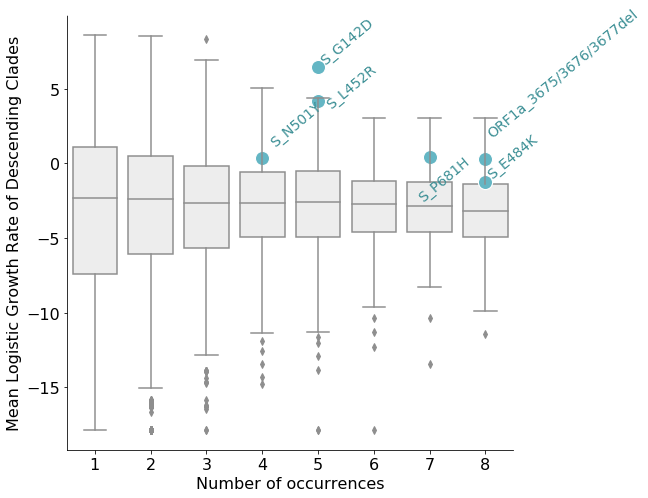

In [54]:
fig, ax = plt.subplots(figsize=(8,8))


sns.boxplot(x='num_occurrences', y='rate', data=df, 
              dodge=True, zorder=1,
              color='#ededed', ax=ax)



sns.scatterplot(x='num_occurrences', y='rate', data=empirical_df, color='#64B6C4', s=200)
for i in range(empirical_df.shape[0]):
    if empirical_df.mutation[i] == 'ORF1a_3675/3676/3677del':
        ax.text(x=empirical_df.num_occurrences[i],
                 y=empirical_df.rate[i]+5.75,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    elif empirical_df.mutation[i] == 'S_P681H':
        ax.text(x=empirical_df.num_occurrences[i]-0.25,
                 y=empirical_df.rate[i]-1.5,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    elif empirical_df.mutation[i] == 'S_L452R':
        ax.text(x=empirical_df.num_occurrences[i]+0.1,
                 y=empirical_df.rate[i]+1.0,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    elif empirical_df.mutation[i] == 'S_N501Y':
        ax.text(x=empirical_df.num_occurrences[i]+0.1,
                 y=empirical_df.rate[i]+2.25,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    else:
        ax.text(x=empirical_df.num_occurrences[i],
                 y=empirical_df.rate[i]+1.75,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))


ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

ax.set_ylabel('Mean Logistic Growth Rate of Descending Clades', fontsize = 16)
ax.set_xlabel('Number of occurrences', fontsize = 16)

plt.yticks(fontsize= 16)
plt.xticks(fontsize= 16)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

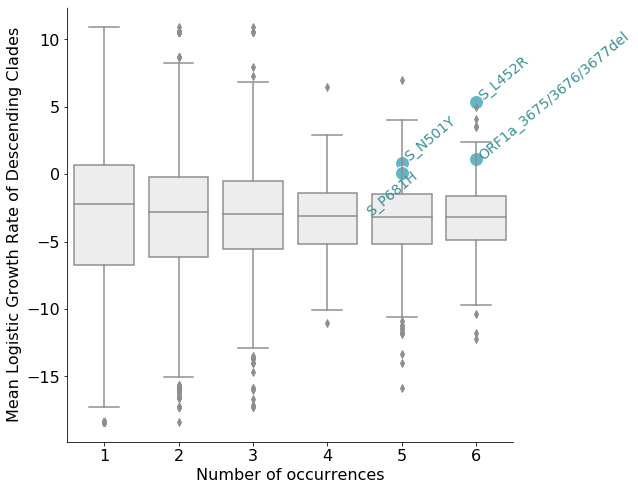

In [540]:
fig, ax = plt.subplots(figsize=(8,8))


# sns.stripplot(x='num_occurrences', y='rate', data=df, 
#               dodge=True, jitter=0.25, zorder=1,
#               alpha=.2, color='#8d8d8d', ax=ax)

sns.boxplot(x='num_occurrences', y='rate', data=df, 
              dodge=True, zorder=1,
              color='#ededed', ax=ax)



sns.scatterplot(x='num_occurrences', y='rate', data=empirical_df, color='#64B6C4', s=200)
for i in range(empirical_df.shape[0]):
    if empirical_df.mutation[i] == 'ORF1a_3675/3676/3677del':
        ax.text(x=empirical_df.num_occurrences[i],
                 y=empirical_df.rate[i]+4.75,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    elif empirical_df.mutation[i] == 'S_P681H':
        ax.text(x=empirical_df.num_occurrences[i]-0.5,
                 y=empirical_df.rate[i]-1.5,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))
    else:
        ax.text(x=empirical_df.num_occurrences[i],
                 y=empirical_df.rate[i]+1.75,
                 s=empirical_df.mutation[i], 
                 ha='left', va='center',
                 fontdict=dict(color='#3c8f95',size=14, rotation=40))


ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

ax.set_ylabel('Mean Logistic Growth Rate of Descending Clades', fontsize = 16)
ax.set_xlabel('Number of occurrences', fontsize = 16)

plt.yticks(fontsize= 16)
plt.xticks(fontsize= 16)

In [ ]:
mean_growth_all_randomization = {x:[] for x in all_mutations_unique}

for i in range(100):
    # randomize positions of mutations on tree
    randomize_tree()
    
    # all_mutations_unique will be the same for randomized and empirical data
    growth_by_precedingmut_dict, s1muts_by_precedingmut_dict = clades_descending_from_randomized_mut(all_mutations_unique)
    
    growth_by_precedingmut_mean, s1muts_by_precedingmut_mean = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict)
    
    for mut, rate in growth_by_precedingmut_mean.items():
        mean_growth_all_randomization[mut].append(rate)
        
    if i == 0:
        null_expectation_df = convergent_evo_dataframe(growth_by_precedingmut_dict, 
                                                       s1muts_by_precedingmut_dict, 
                                                       independent_occurrences_all_mutations)
    
    
null_expectation_mean_growth = []
for k,v in mean_growth_all_randomization.items():
    if len(v)!=0:
        mean_growth = sum(v)/len(v)
        lower_95_percentile = np.percentile(sorted(v), 2.5)
        upper_95_percentile =np.percentile(sorted(v), 97.5)
        
        null_expectation_mean_growth.append({'mutation': k, 'null_mean_growth': mean_growth, 
                                             'lower_95': lower_95_percentile, 'upper_95': upper_95_percentile})
# null_expectation_mean_growth = {k:(sum(v)/len(v)) for k,v in mean_growth_all_randomization.items() if len(v)!=0}
null_mean_growth_df = pd.DataFrame(null_expectation_mean_growth)


null_expectation_df = null_expectation_df[['mutation', 'independent_occurrences']]
null_expectation_df = null_expectation_df.merge(null_mean_growth_df, on='mutation')



In [17]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [16]:
# Function to find duplicates in mutation list 
# and keep only one instance of the duplicated mutation
def remove_duplicate_mutations(mutation_list):

    mutation_list = list(mutation_list)
    seen = {}
    dupes = []

    for x in mutation_list:
        if x not in seen:
            seen[x] = 1
        else:
            if seen[x] >= 1:
                dupes.append(x)
            seen[x] += 1

    nondupe_list = [x for x in seen.keys()]
    
    return nondupe_list, dupes

In [15]:
def remove_ancestral_muts(list_of_muts, node):
    # need to check that these mutation haven't already occurred on ancestors of this branch
    node_path = get_parent(tree, node)[:-1]

    dont_use = []
    for mut in list_of_muts:
        for parent in node_path:
            if mut in parent.random_muts:
                dont_use.append(mut)
    
    
    list_of_muts_edited = [x for x in list_of_muts if x not in dont_use]

    return list_of_muts_edited, dont_use


In [14]:
def randomize_tree():
    # shuffle the bag of mutations
    shuffled_bag_of_muts = np.random.choice(bag_of_mutations, len(bag_of_mutations), replace = False)

    # shuffle the list of number of mutations per node
    shuffled_muts_per_branch = np.random.choice(mut_counts, len(mut_counts), replace = False)
    

    for node in tree.find_clades():

        # add attribute for randomized muts
        node.random_muts = []

        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=10:

            # randomly choose the number of mutations that should occur on branch
            num_muts_on_branch = shuffled_muts_per_branch[-1:][0]
            # then remove this value from the list
            shuffled_muts_per_branch = shuffled_muts_per_branch[:-1]


            if num_muts_on_branch != 0:

                # randomly choose that many mutations to throw on this node. Without replacement
                randomized_muts = shuffled_bag_of_muts[-num_muts_on_branch:]
                # then remove the chosen muts from the bag
                shuffled_bag_of_muts = shuffled_bag_of_muts[:-num_muts_on_branch]

                # edit the list of random mutations if the mutations are found an the ancestor of this node 
                # or if there are duplicates

                # initialize list of mutations that will not be added to this node 
                # and which should be added back to the bag
                add_back_to_bag = []

                for i in range(100):
                    randomized_muts, dont_use = remove_ancestral_muts(randomized_muts, node)
                    if len(dont_use) != 0:
                        randomized_muts+=(x for x in shuffled_bag_of_muts[-len(dont_use):])
                        # remove the newly chosen muts from the bag
                        shuffled_bag_of_muts = shuffled_bag_of_muts[:-len(dont_use)]
                        # add unused mutations back to bag
                        add_back_to_bag+=dont_use

                    randomized_muts, dupes = remove_duplicate_mutations(randomized_muts)
                    if len(dupes) != 0:
                        randomized_muts+=(x for x in shuffled_bag_of_muts[-len(dupes):])
                        # remove the newly chosen muts from the bag
                        shuffled_bag_of_muts = shuffled_bag_of_muts[:-len(dupes)]
                        # add unused mutations back to bag
                        add_back_to_bag+=dupes

                    if len(dont_use) == 0 and len(dupes) == 0:
                        break



                # add the duplicates back into the bag
                np.append(shuffled_bag_of_muts, np.array(add_back_to_bag))


                random.shuffle(shuffled_bag_of_muts)

                # add the random mutations to this node
                node.random_muts = randomized_muts


            


In [13]:
def clades_descending_from_randomized_mut(all_mutations_unique):

    #initialize dict for storing all growth rates observed in clades descending from {key} mutation
    growth_by_precedingmut_dict = {k:[] for k in all_mutations_unique}


    #initialize dict for storing S1 mutation counts observed in clades descending from {key} mutation
    s1muts_by_precedingmut_dict = {k:[] for k in all_mutations_unique}



    for node in tree.find_clades():
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=10:
        
            node_path = get_parent(tree, node)


            s1_mutations = None
            if "S1_mutations" in node.node_attrs:
                s1_mutations = node.node_attrs["S1_mutations"]["value"]


            logistic_growth = None
            if "logistic_growth" in node.node_attrs:
                logistic_growth = node.node_attrs["logistic_growth"]["value"]


            for parent in node_path[:-1]:
                for gene_mutation in node.random_muts:
                    
                    if logistic_growth!=None:
                        growth_by_precedingmut_dict[gene_mutation].append(logistic_growth)

                    if s1_mutations!=None:
                        s1muts_by_precedingmut_dict[gene_mutation].append(s1_mutations)
                                        
    # get rid of empty entries
    growth_by_precedingmut_dict = {k:v for k,v in growth_by_precedingmut_dict.items() if v}
    s1muts_by_precedingmut_dict = {k:v for k,v in s1muts_by_precedingmut_dict.items() if v}
    
    
    return growth_by_precedingmut_dict, s1muts_by_precedingmut_dict


In [12]:
def calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict):
    
    # to consider: clade nesting-> just take unique values? 
    # Here, all nested clades are averaging, giving more weight to larger clades
    growth_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_dict.items()}

    # Here, only unique values are taken, to limit the effect of nesting clades
    growth_by_precedingmut_limit_nesting = {k:list(set(v)) for k,v in growth_by_precedingmut_dict.items()}
    growth_by_precedingmut_limit_nesting_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_limit_nesting.items()}

    # this will give more weight to larger clades
    s1muts_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in s1muts_by_precedingmut_dict.items() if len(v)!=0}

    return growth_by_precedingmut_limit_nesting_mean, s1muts_by_precedingmut_mean

In [11]:
def convergent_evo_dataframe(growth_by_precedingmut_dict, 
                             s1muts_by_precedingmut_dict, independent_occurrences_all_mutations):
    
    growth_by_precedingmut_mean, s1muts_by_precedingmut_mean = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict)
    
    # make dataframe where each row is a mutation
    # and columns contain number of independent occurrences, average growth rates, and number of S1 mutations

    convergent_evo_list = []

    for mut, occurrences in independent_occurrences_all_mutations.items():
        if mut in s1muts_by_precedingmut_mean.keys():
            avg_s1_muts = s1muts_by_precedingmut_mean[mut]
        else:
            avg_s1_muts = None

        if mut in growth_by_precedingmut_mean.keys():
            avg_growth = growth_by_precedingmut_mean[mut]
        else:
            avg_growth = None



        # for deletions that span multiple consecutive residues, condense this into one row
        if mut == 'ORF1a_S3675-': 
            mut = 'ORF1a_3675/3676/3677del'


        elif mut == 'S_H69-':
            mut = 'S_69/70del'

        if mut not in ['ORF1a_G3676-', 'ORF1a_F3677-', 'S_V70-']:
            convergent_evo_list.append({'mutation': mut, 'independent_occurrences': occurrences, 
                                        'avg_s1_muts': avg_s1_muts, 'avg_growth': avg_growth
                                       })

    convergent_evo_df = pd.DataFrame(convergent_evo_list)


    # multiply occurrences times growth
    convergent_evo_df['occurrences_times_growth']= convergent_evo_df['independent_occurrences']*convergent_evo_df['avg_growth']

    
    return convergent_evo_df
